In [1]:
import os
os.environ['XLA_FLAGS'] = "--xla_force_host_platform_device_count=8"

from jax import config
config.update("jax_enable_x64", True)

import jax
from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

In [2]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
data = pd.read_csv(pm.get_data("efron-morris-75-data.tsv"), sep="\t")

N = len(data)
player_names = data["FirstName"] + " " + data["LastName"]
# coords = {"player_names": player_names.tolist()}

with pm.Model() as baseball_model:
    at_bats = pm.MutableData("at_bats", data["At-Bats"].to_numpy())
    n_hits = pm.MutableData("n_hits", data["Hits"].to_numpy())
    baseball_model.add_coord("player_names", player_names, mutable=True)

    phi = pm.Uniform("phi", lower=0.0, upper=1.0)

    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", pm.math.exp(kappa_log))

    theta = pm.Beta("theta", alpha=phi * kappa, beta=(1.0 - phi) * kappa, dims="player_names")
    y = pm.Binomial("y", n=at_bats, p=theta, observed=n_hits, dims="player_names")

/home/junpenglao/miniconda3/envs/blackjax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Compiling...
/home/junpenglao/miniconda3/envs/blackjax/lib/python3.11/site-packages/pymc/sampling/jax.py:454: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
Compilation time = 0:00:01.219631
Sampling...
Sampling time = 0:00:04.369768
Transforming variables...
Transformation time = 0:00:00.124327


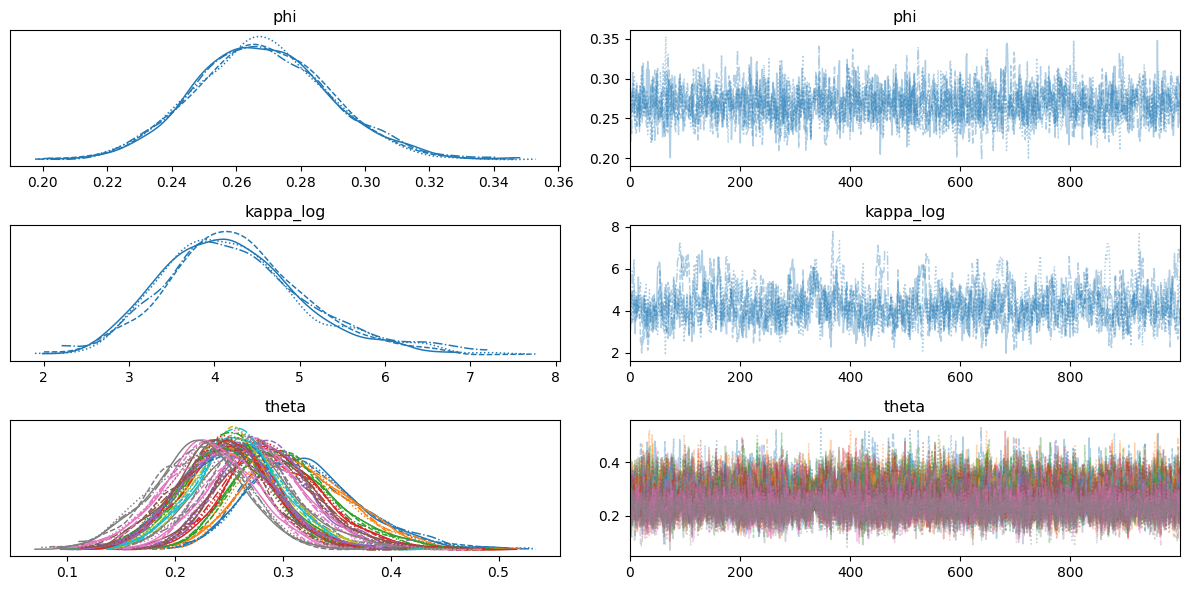

In [4]:
with baseball_model:
    idata0 = pm.sample(
        1000, nuts_sampler="blackjax", progressbar=True,
        nuts_sampler_kwargs={"chain_method": "parallel"}
    )

az.plot_trace(idata0, var_names=["phi", "kappa_log", "theta"], compact=True)
plt.tight_layout();

In [5]:
from pymc.sampling_jax import get_jaxified_logp

rvs = [rv.name for rv in baseball_model.value_vars]
logdensity_fn = get_jaxified_logp(baseball_model)

# Get the initial position from PyMC
init_position_dict = baseball_model.initial_point()
init_position = [init_position_dict[rv] for rv in rvs]

In [6]:
import blackjax
from blackjax.util import generate_gaussian_noise

In [7]:
pf = blackjax.pathfinder(logdensity_fn)
rng_key, approx_key, init_key = jax.random.split(rng_key, 3)

# init_position = generate_gaussian_noise(init_key, init_position, sigma=0.05)

state, pf_info = pf.approximate(approx_key, init_position, num_samples=200, maxcor=15, maxiter=500)
rng_key, sample_key = jax.random.split(rng_key)
samples, _ = pf.sample(sample_key, state, 4000)

In [8]:
state.position

[Array(-0.95179864, dtype=float64),
 Array(1.35881398, dtype=float64),
 Array([-0.58997911, -0.65704227, -0.72658096, -0.79905756, -0.87495716,
        -0.87495716, -0.95478719, -1.03907484, -1.12836208, -1.12836208,
        -1.22319781, -1.22319781, -1.22319781, -1.22319781, -1.22319781,
        -1.32412686, -1.43167625, -1.54633888], dtype=float64)]

In [9]:
import jaxopt

from jax.flatten_util import ravel_pytree
initial_position_flatten, unravel_fn = ravel_pytree(init_position)
objective_fn = lambda x: -logdensity_fn(unravel_fn(x))
scipy_lbfgs = jaxopt.ScipyMinimize(fun=objective_fn, method='L-BFGS-B', maxiter=500)
output = scipy_lbfgs.run(initial_position_flatten)
unravel_fn(output.params)

[Array(-1.0667047, dtype=float64),
 Array(2.04323611, dtype=float64),
 Array([-1.16372889, -1.13254761, -1.10556908, -1.08331142, -1.06628567,
        -1.06628567, -1.05499574, -1.04993757, -1.05159756, -1.05159756,
        -1.0604507 , -1.0604507 , -1.0604507 , -1.0604507 , -1.0604507 ,
        -1.07695855, -1.10156743, -1.13470692], dtype=float64)]

In [10]:
from blackjax.optimizers.lbfgs import _minimize_lbfgs
(_, status), history = _minimize_lbfgs(
        objective_fn,
        initial_position_flatten,
        maxiter=500,
        maxcor=10,
        maxls=1000,
        gtol=1e-08,
        ftol=1e-05,
    )
unravel_fn(history.x[-1])

[Array(-1.13806966, dtype=float64),
 Array(3.43092041, dtype=float64),
 Array([-1.1380697 , -1.13807004, -1.13807006, -1.13806988, -1.13806963,
        -1.13806963, -1.13806943, -1.13806936, -1.13806947, -1.13806947,
        -1.13806974, -1.13806974, -1.13806974, -1.13806974, -1.13806974,
        -1.13807004, -1.13807014, -1.13806959], dtype=float64)]

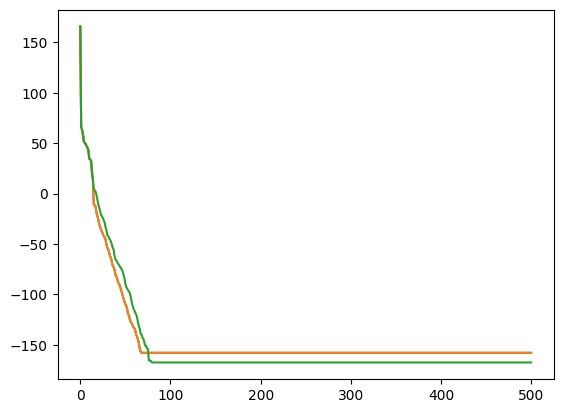

In [11]:
plt.plot(history.f)
plt.plot(jax.vmap(objective_fn)(history.x))
plt.plot(-jax.vmap(logdensity_fn)(pf_info.path.position))

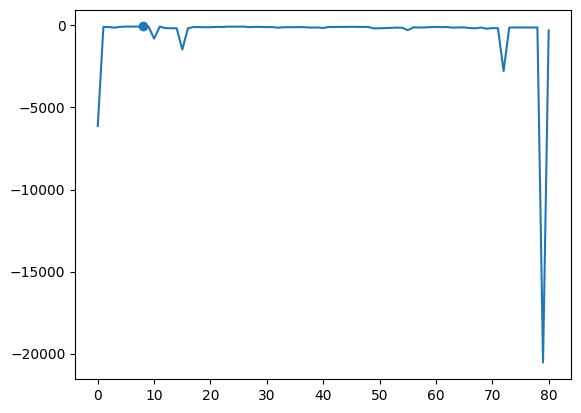

In [12]:
plt.plot(pf_info.path.elbo)
plt.scatter(np.argmax(pf_info.path.elbo), pf_info.path.elbo.max())

In [13]:
output2 = jaxopt.LBFGS(fun=objective_fn, maxiter=50).run(initial_position_flatten)
unravel_fn(output2.params)

[Array(-1.10979558, dtype=float64),
 Array(3.24501642, dtype=float64),
 Array([-1.10978742, -1.10979457, -1.10979846, -1.10979991, -1.10979976,
        -1.10979976, -1.10979874, -1.10979746, -1.10979631, -1.10979631,
        -1.10979547, -1.10979547, -1.10979547, -1.10979547, -1.10979547,
        -1.109795  , -1.10979485, -1.10979451], dtype=float64)]

In [14]:
samples, _ = pf.sample(sample_key, state, 4000)
# samples, _ = pf.sample(sample_key, jax.tree_map(lambda x: x[10], pf_info.path), 4000)

In [15]:
idata = az.from_dict(
    posterior={k: v.reshape(4, 1000, -1).squeeze()
               for k, v in zip(baseball_model.initial_point().keys(), samples)},
    coords=idata0.posterior.coords)
idata.posterior['phi'] = ('chain', 'draw'), pm.distributions.transforms.Interval(lower=0.0, upper=1.0).backward(
    idata.posterior['phi_interval__'].values).eval()

idata.posterior['kappa_log'] = ('chain', 'draw'), np.exp(idata.posterior['kappa_log_log__'].values)
idata.posterior['theta'] = ('chain', 'draw', 'theta_logodds___dim_0'), pm.distributions.transforms.logodds.backward(
    idata.posterior['theta_logodds__'].values).eval()

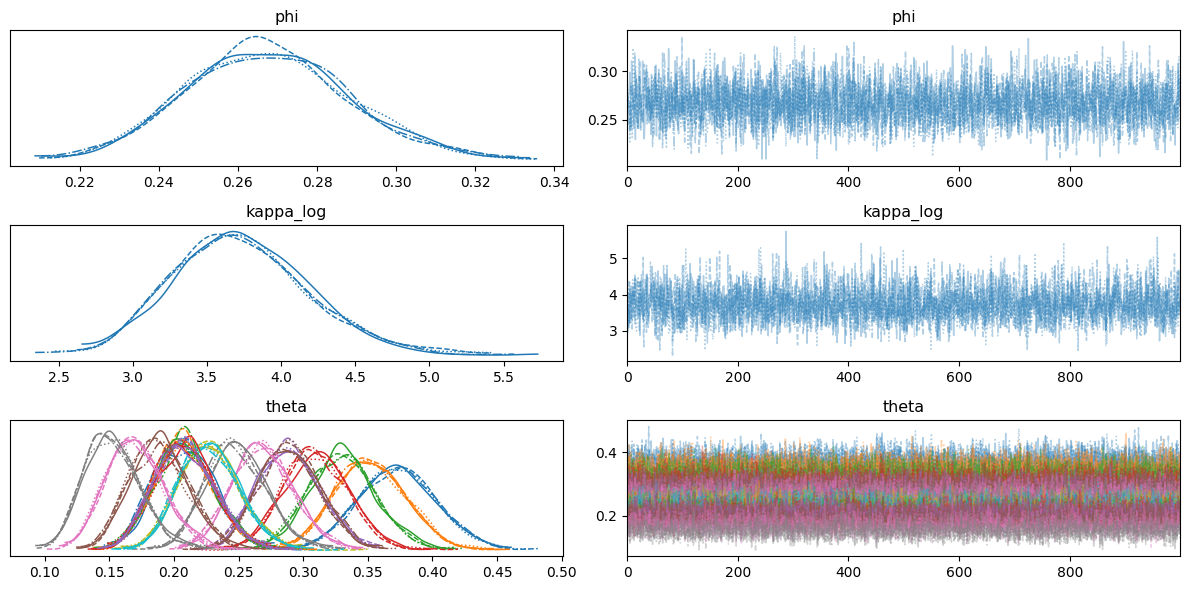

In [16]:
az.plot_trace(idata, var_names=["phi", "kappa_log", "theta"])
plt.tight_layout();

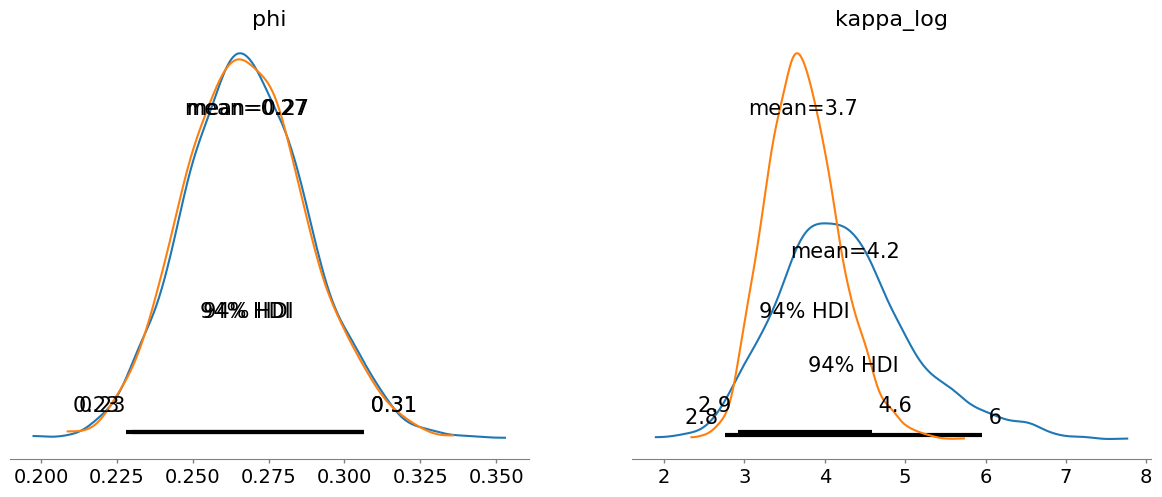

In [17]:
axes = az.plot_posterior(idata0, var_names=["phi", "kappa_log"], round_to=2);
az.plot_posterior(idata, var_names=["phi", "kappa_log"], round_to=2, ax=axes, color="C1");

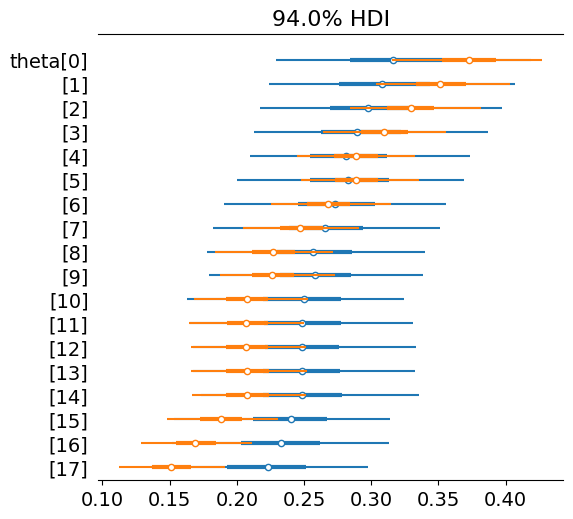

In [18]:
ax = az.plot_forest(idata0, var_names=["theta"], combined=True)
ax = az.plot_forest(idata, var_names=["theta"], combined=True, colors="C1", ax=ax);

In [19]:
def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform=lambda x: x.position):
    init_key, tune_key, run_key = jax.random.split(key, 3)
    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )
    # build the kernel
    kernel = blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
    )
    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
    )
    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )
    # run the sampler
    _, samples, _ =  blackjax.util.run_inference_algorithm(
            rng_key=run_key,
            initial_state_or_position=blackjax_state_after_tuning,
            inference_algorithm=sampling_alg,
            num_steps=num_steps,
            transform=transform,
            progress_bar=True,
        )
    return samples

In [26]:
%%time

samples = jax.pmap(lambda x, k: run_mclmc(logdensity_fn, 1000, x, k))(
    jax.tree_map(lambda x: np.repeat(x[None, ...], 4, axis=0), init_position),
    jax.random.split(sample_key, 4))

Compiling.. :   0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 4.66 s, sys: 166 ms, total: 4.83 s
Wall time: 4.79 s


Running chain 0:  60%|██████    | 600/1000 [00:04<00:02, 145.43it/s]

Running chain 0: : 3500it [00:04, 847.65it/s]                       


In [21]:
idata_mclmc = az.from_dict(
    posterior={k: v
               for k, v in zip(baseball_model.initial_point().keys(), samples)},
    coords=idata0.posterior.coords)
idata_mclmc.posterior['phi'] = ('chain', 'draw'), pm.distributions.transforms.Interval(lower=0.0, upper=1.0).backward(
    idata_mclmc.posterior['phi_interval__'].values).eval()

idata_mclmc.posterior['kappa_log'] = ('chain', 'draw'), np.exp(idata_mclmc.posterior['kappa_log_log__'].values)
idata_mclmc.posterior['theta'] = ('chain', 'draw', 'theta_logodds___dim_0'), pm.distributions.transforms.logodds.backward(
    idata_mclmc.posterior['theta_logodds__'].values).eval()

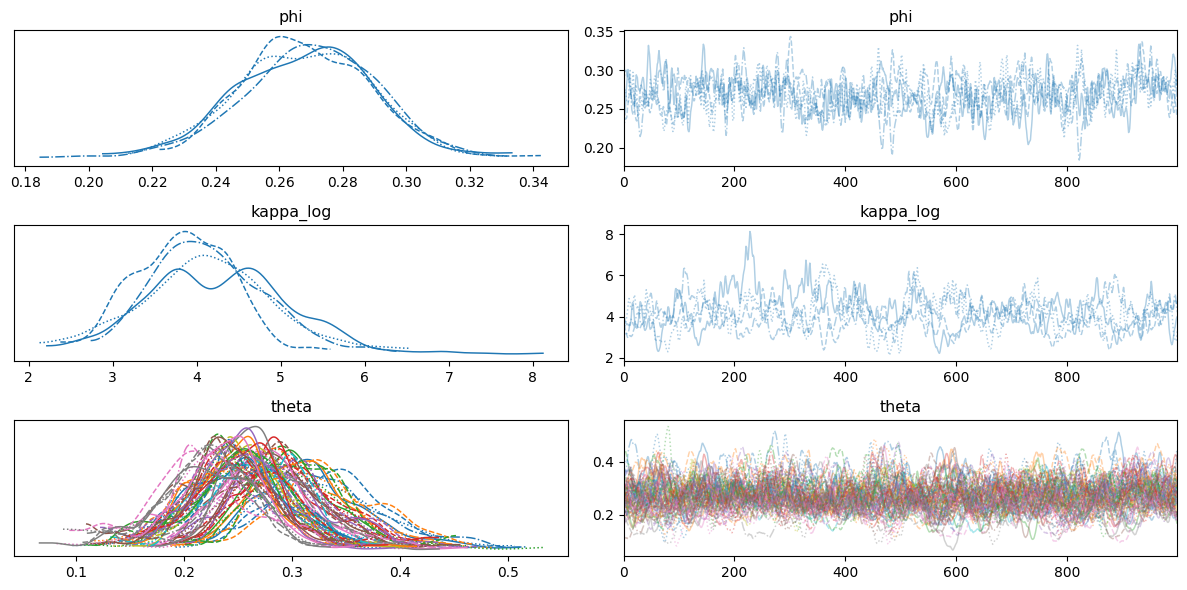

In [22]:
az.plot_trace(idata_mclmc, var_names=["phi", "kappa_log", "theta"])
plt.tight_layout();

In [23]:
az.summary(idata_mclmc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi_interval__,-1.004,0.112,-1.206,-0.787,0.007,0.005,240.0,557.0,1.01
kappa_log_log__,1.395,0.190,1.023,1.741,0.021,0.016,74.0,138.0,1.07
theta_logodds__[0],-0.724,0.250,-1.231,-0.281,0.017,0.012,212.0,260.0,1.02
theta_logodds__[1],-0.781,0.233,-1.229,-0.331,0.017,0.012,193.0,278.0,1.04
theta_logodds__[2],-0.835,0.218,-1.273,-0.443,0.016,0.011,188.0,265.0,1.02
theta_logodds__[3],-0.871,0.221,-1.285,-0.453,0.015,0.011,221.0,347.0,1.01
theta_logodds__[4],-0.905,0.247,-1.353,-0.448,0.016,0.011,238.0,415.0,1.02
theta_logodds__[5],-0.929,0.222,-1.379,-0.540,0.015,0.010,228.0,356.0,1.01
theta_logodds__[6],-0.984,0.234,-1.410,-0.515,0.015,0.011,244.0,274.0,1.01
theta_logodds__[7],-1.000,0.213,-1.396,-0.579,0.014,0.010,247.0,274.0,1.01


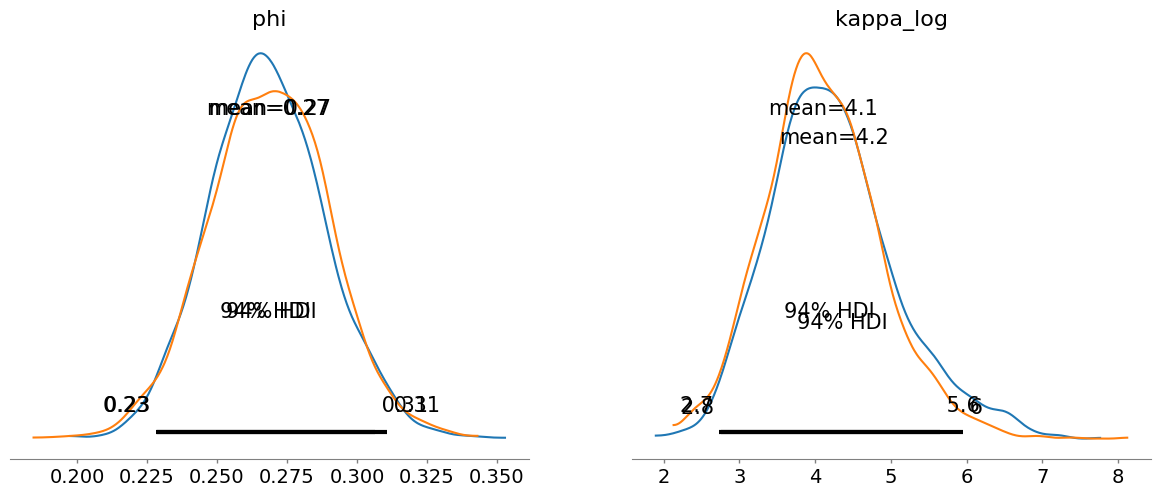

In [24]:
axes = az.plot_posterior(idata0, var_names=["phi", "kappa_log"], round_to=2);
az.plot_posterior(idata_mclmc, var_names=["phi", "kappa_log"], round_to=2, ax=axes, color="C1");

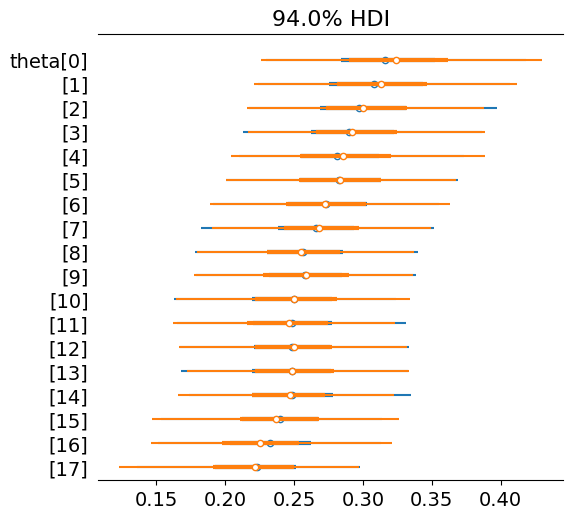

In [25]:
ax = az.plot_forest(idata0, var_names=["theta"], combined=True)
ax = az.plot_forest(idata_mclmc, var_names=["theta"], combined=True, colors="C1", ax=ax);